In [1]:
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from itertools import cycle
from scipy.cluster.hierarchy import dendrogram, linkage  

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
style.use('fivethirtyeight')

In [2]:
pd.options.display.float_format = '{:,.4f}'.format

plt.rc('figure', figsize=(10.0, 5.0))
matplotlib.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

In [3]:
with open('./data/processed/answer_time_series.pkl', 'rb') as picklefile:
    answer_time_series = pickle.load(picklefile)

In [4]:
answer_time_series.dropna(inplace=True)
answer_time_series['id'] = answer_time_series['id'].astype(int)
top_answerer = answer_time_series[answer_time_series.iloc[:,1:].sum(axis=1)>26]

Text(0.5,1,'Histogram of user answer std')

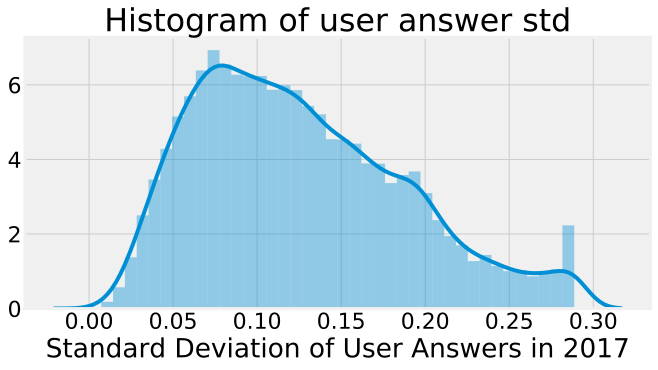

In [5]:
top_answerer_norm = top_answerer.values[:,1:]/top_answerer.values[:,1:].sum(axis=1)[:,np.newaxis]
top_answerer_norm = pd.DataFrame(top_answerer_norm, columns=top_answerer.columns[1:], index=top_answerer['id'])
top_answerer_norm['std'] = top_answerer_norm.std(axis=1)
sns.distplot(top_answerer_norm['std'])
plt.xlabel('Standard Deviation of User Answers in 2017')
plt.title('Histogram of user answer std')

In [6]:
top_answerer_norm.head()

,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712,std
id,,,,,,,,,,,,,
51,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2887
152,0.0000,0.0000,0.1786,0.0000,0.0000,0.0000,0.0000,0.0000,0.7143,0.1071,0.0000,0.0000,0.2068
267,0.0328,0.0246,0.0902,0.0820,0.1066,0.1967,0.0738,0.2049,0.0410,0.0000,0.0984,0.0492,0.0636
369,0.0980,0.0392,0.0000,0.0000,0.0196,0.0588,0.0392,0.2353,0.0784,0.1373,0.2353,0.0588,0.0811
476,0.0426,0.0452,0.0426,0.0612,0.0957,0.1090,0.1197,0.1144,0.1064,0.0931,0.0798,0.0904,0.0287


In [7]:
def detectChanges(values, window):
    status_dict = {True:'Inactive', False:'Active'}
    changes = 0
    track_status = []
    status = (np.sum([value!=0 for value in values[:window]]) == 0)
    track_status.append(status_dict[status])
    for index in range(1, len(values)-window+1):
        new_status = (np.sum([value!=0 for value in values[index:index+window]]) == 0)
        if (new_status != status):
            changes = changes + 1
            status = new_status
            track_status.append(status_dict[status])
    return changes, tuple(track_status)

In [8]:
top_answerer_norm[['changes','change_history']]  = top_answerer_norm.apply(lambda x:pd.Series(list(detectChanges(x[:-1],3)), index=['changes','change_history']), axis=1)

In [9]:
top_answerer_norm[top_answerer_norm['change_history']==('Inactive',)].head()

,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712,std,changes,change_history
id,,,,,,,,,,,,,,,


In [15]:
change_count = top_answerer_norm.groupby(['changes', 'change_history'])['std'].count().reset_index().rename(columns = {'std':'count'})
change_count

,changes,change_history,count
0,0,"(Active,)",8106
1,1,"(Active, Inactive)",1944
2,1,"(Inactive, Active)",2909
3,2,"(Active, Inactive, Active)",1891
4,2,"(Inactive, Active, Inactive)",871
5,3,"(Active, Inactive, Active, Inactive)",282
6,3,"(Inactive, Active, Inactive, Active)",346
7,4,"(Active, Inactive, Active, Inactive, Active)",65
8,4,"(Inactive, Active, Inactive, Active, Inactive)",12
9,5,"(Inactive, Active, Inactive, Active, Inactive,...",1


More than 26 comments / Use
    
changes	change_history	std

If we use 3 months as inactive window, then the following users can be correctly classified
0	0	(Active,)	8106 
1	1	(Active, Inactive)	1944
2	1	(Inactive, Active)	2909

The following users will not be correctly classified
3	2	(Active, Inactive, Active)	1891
4	2	(Inactive, Active, Inactive)	871
5	3	(Active, Inactive, Active, Inactive)	282
6	3	(Inactive, Active, Inactive, Active)	346
7	4	(Active, Inactive, Active, Inactive, Active)	65
8	4	(Inactive, Active, Inactive, Active, Inactive)	12
9	5	(Inactive, Active, Inactive, Active, Inactive,...	1

In [21]:
print('Total percentage of miss classification is:{0:0.2f}'.format(
change_count.iloc[3:]['count'].sum()/change_count.iloc[:]['count'].sum()))

Total percentage of miss classification is:0.21


In [22]:
top_answerer_4mon = top_answerer_norm
top_answerer_4mon[['changes','change_history']]  = top_answerer_norm.apply(lambda x:pd.Series(list(detectChanges(x[:-3],4)), index=['changes','change_history']), axis=1)

In [24]:
change_count_4mon = top_answerer_4mon.groupby(['changes', 'change_history'])['std'].count().reset_index().rename(columns = {'std':'count'})
change_count_4mon

,changes,change_history,count
0,0,"(Active,)",10102
1,1,"(Active, Inactive)",1838
2,1,"(Inactive, Active)",2765
3,2,"(Active, Inactive, Active)",1218
4,2,"(Inactive, Active, Inactive)",372
5,3,"(Active, Inactive, Active, Inactive)",57
6,3,"(Inactive, Active, Inactive, Active)",72
7,4,"(Active, Inactive, Active, Inactive, Active)",3


In [25]:
print('Total percentage of miss classification is:{0:0.2f}'.format(
change_count_4mon.iloc[3:]['count'].sum()/change_count_4mon.iloc[:]['count'].sum()))

Total percentage of miss classification is:0.10


## Conclusion:
## *Let's define <span style=' color:red'>4 months</span> as window to identify inactive answerer*

In [26]:
with pickle
top_answerer.id

,id,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712
8,51,0,0,0,0,30,0,0,0,0,0,0,0
30,152,0,0,5,0,0,0,0,0,20,3,0,0
51,267,4,3,11,10,13,24,9,25,5,0,12,6
63,369,5,2,0,0,1,3,2,12,4,7,12,3
78,476,16,17,16,23,36,41,45,43,40,35,30,34
96,582,0,0,0,0,0,4,0,8,31,29,0,0
136,893,4,15,2,4,0,0,3,3,3,6,5,3
139,905,8,9,17,22,4,0,10,15,4,3,1,2
152,967,6,2,4,5,8,0,5,5,3,6,1,4
175,1114,0,1,1,0,17,11,2,2,0,0,0,1
